<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignment_2/blob/main/Assignment_2_QB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil

# Source folder in Google Drive
src_folder = '/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 2/inaturalist_12K'

# Destination in Colab's local storage
dst_folder = '/content/inaturalist_12K'

# Copy the entire folder
shutil.copytree(src_folder, dst_folder)

'/content/inaturalist_12K'

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

In [17]:
weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)

In [18]:
train_path = '/content/inaturalist_12K/train'

train_ratio = 0.8
full_train_dataset = datasets.ImageFolder(root=train_path, transform=weights.transforms())
# Set your train/val split ratio
total_size = len(full_train_dataset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size

# Split the dataset

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

In [19]:
# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last two trainable layers (layer4 and fc)
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes

# Loss function and optimizer (only train final layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# ------------------------------
# Training Function
# ------------------------------
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()                   # Zero gradients
        outputs = model(inputs)                 # Forward pass
        loss = criterion(outputs, labels)       # Compute loss
        loss.backward()                         # Backward pass
        optimizer.step()                        # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)           # Get predicted class
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), correct / total


# ------------------------------
# Evaluation Function
# ------------------------------
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_total += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss_total / len(loader), correct / total


# val loss before training

val_loss, val_acc = evaluate(model, val_loader, criterion, device)
print(f"accuracy before training")
print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc*100:.2f}%")

# ------------------------------
# Main Training Loop
# ------------------------------
import wandb
wandb.login(key="b81ae278300a216ce5380e07b52d628e2dd6eb69")
run = wandb.init(entity="arunangshudutta218-iitm", project='dl_assgn_2_q_B3')

epochs = 5
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc*100:.2f}%")

    wandb.log({'tr_loss' : train_loss, 'tr_accuracy' : train_acc, 'val_loss' : val_loss, 'val_accuracy' : val_acc})
    #wandb.log({'tr_loss' : train_loss, 'tr_accuracy' : train_acc, 'test_loss' : test_loss, 'test_accuracy' : test_acc})

run.finish()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


accuracy before training
Val   Loss: 2.4232 | Val   Accuracy: 8.20%


tr_accuracy,▁▆▆▇▇▇███
tr_loss,█▃▃▂▂▂▁▁▁
val_accuracy,▃▆▅█▇▆█▄▁
val_loss,▄▂▃▁▃▃▁▃█
tr_accuracy,0.81435
tr_loss,0.55488
val_accuracy,0.757
val_loss,0.75783



Epoch 1/5


Train Loss: 0.9853 | Train Accuracy: 68.60%
Val   Loss: 0.6736 | Val   Accuracy: 78.55%

Epoch 2/5


Train Loss: 0.7155 | Train Accuracy: 77.06%
Val   Loss: 0.6130 | Val   Accuracy: 79.85%

Epoch 3/5


Train Loss: 0.6568 | Train Accuracy: 78.52%
Val   Loss: 0.6638 | Val   Accuracy: 78.55%

Epoch 4/5


Train Loss: 0.6304 | Train Accuracy: 79.31%
Val   Loss: 0.6353 | Val   Accuracy: 78.75%

Epoch 5/5


Train Loss: 0.6118 | Train Accuracy: 79.77%
Val   Loss: 0.6530 | Val   Accuracy: 78.80%


tr_accuracy,▁▆▇██
tr_loss,█▃▂▁▁
val_accuracy,▁█▁▂▂
val_loss,█▁▇▄▆
tr_accuracy,0.79772
tr_loss,0.61184
val_accuracy,0.788
val_loss,0.65295


In [20]:
test_path = '/content/inaturalist_12K/val'

test_dataset = datasets.ImageFolder(root=test_path, transform=weights.transforms())
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Accuracy of testing dataset")
print(f"Test   Loss: {test_loss:.4f} | Test   Accuracy: {test_acc*100:.2f}%")


Accuracy of testing dataset
Test   Loss: 0.6366 | Test   Accuracy: 79.05%


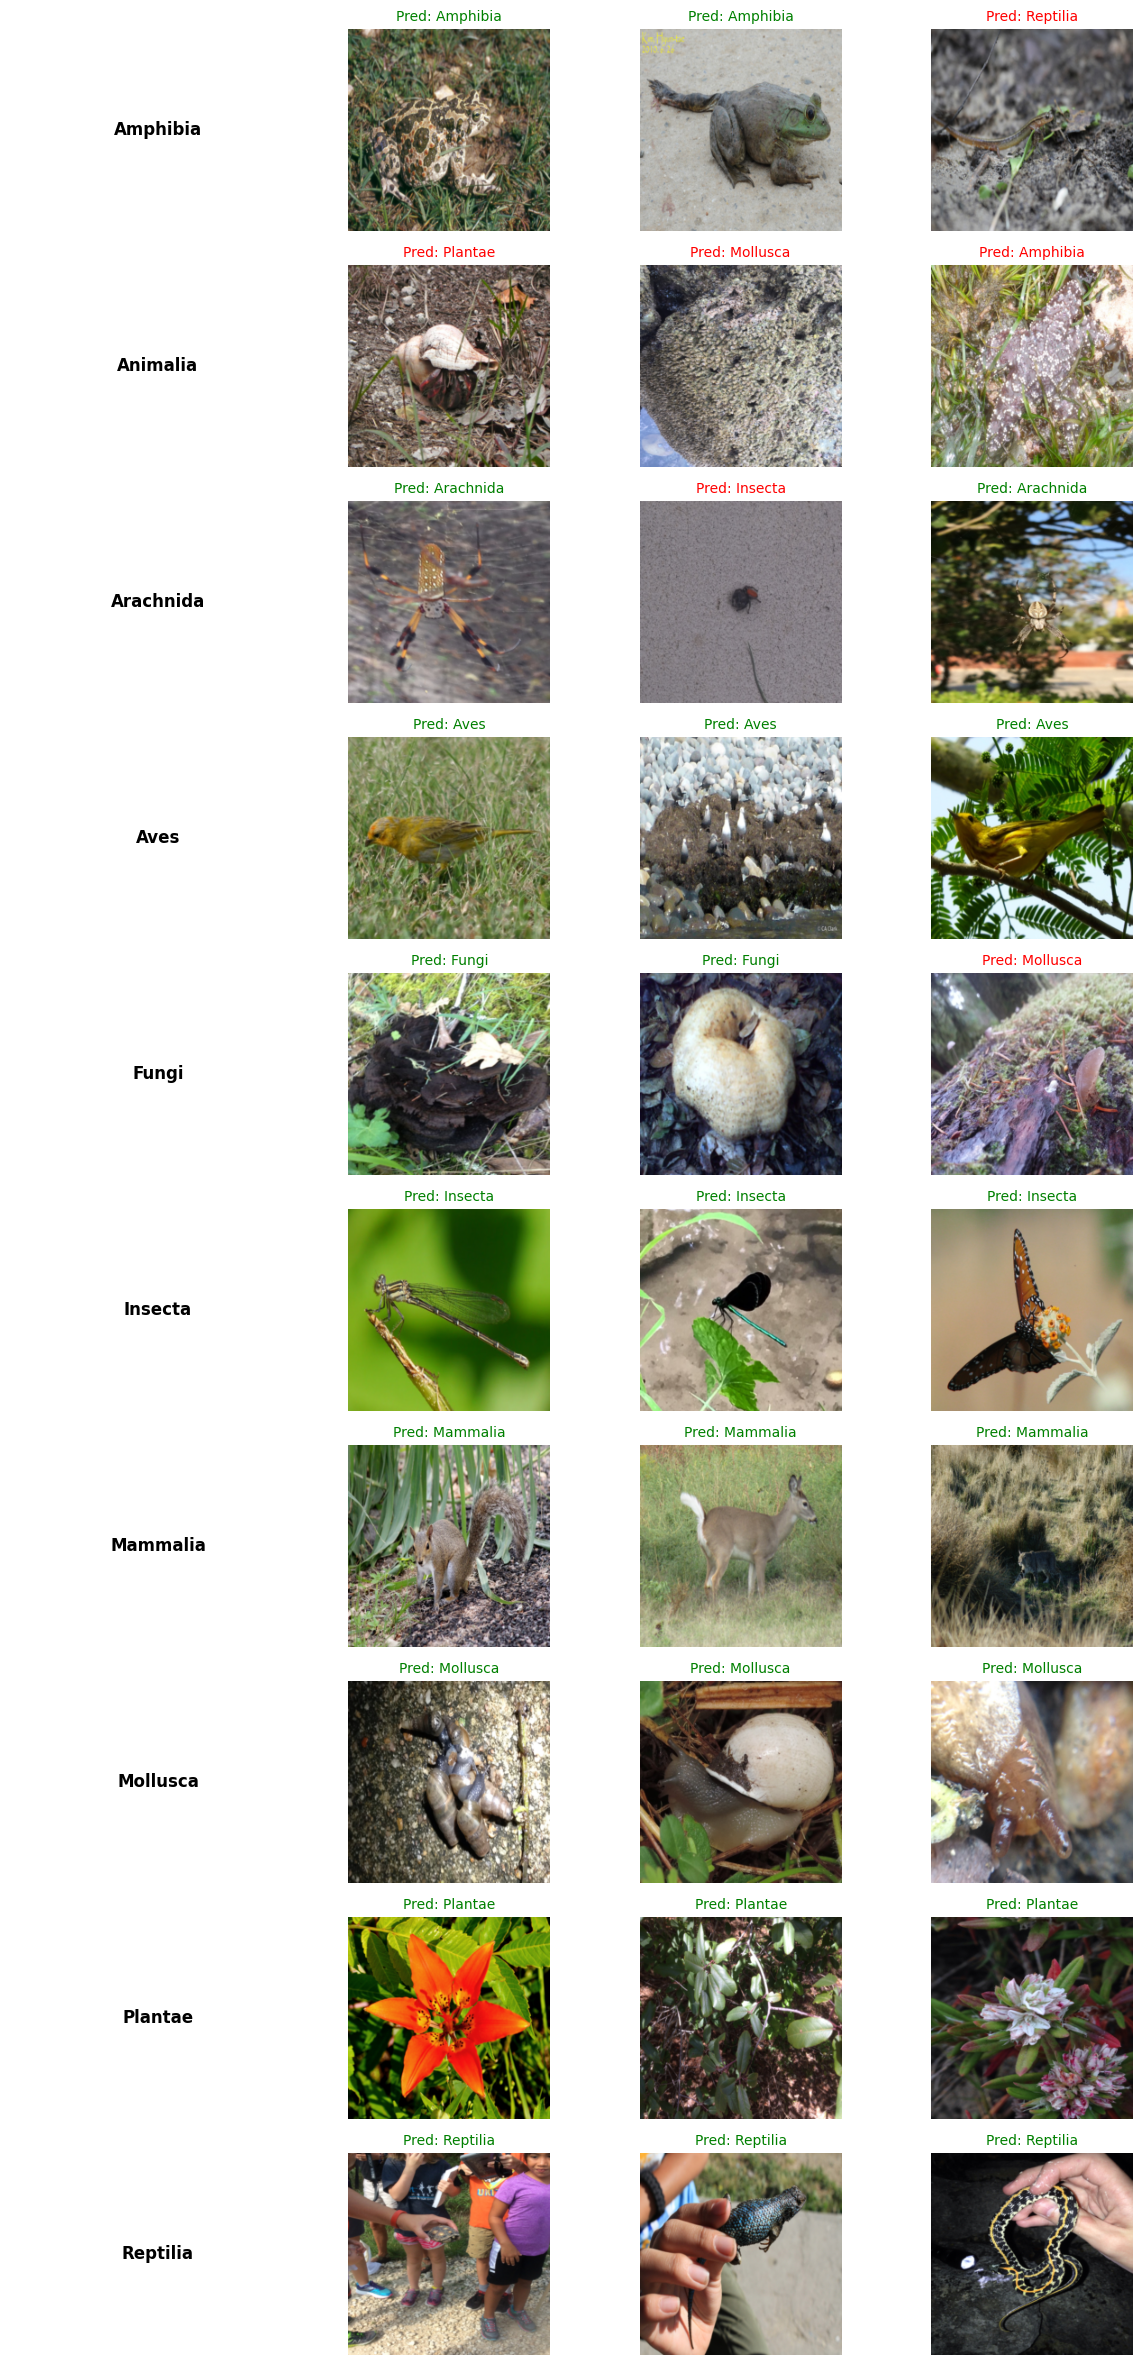

In [21]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ===== CONFIG =====
root_folder = '/content/inaturalist_12K/val'
model.eval()

transform = weights.transforms()

transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to a common shape
    transforms.ToTensor(),          # convert image to PyTorch tensor
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize (assuming RGB images)
])

# ===== Load 3 images per class from folder =====
def load_images_per_class(folder, transform,transform2, max_images=3):
    class_samples = {}
    class_samples2 = {}
    class_names = sorted(os.listdir(folder))

    for cls in class_names:
        cls_path = os.path.join(folder, cls)
        if not os.path.isdir(cls_path):
            continue

        images = []
        images2 = []
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(cls_path, fname)
                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img)
                images.append(img_tensor)

                img_tensor2 = transform2(img)
                images2.append(img_tensor2)
                if len(images) == max_images:
                    break
        class_samples[cls] = images
        class_samples2[cls] = images2
    return class_samples,class_samples2, class_names

# ===== Visualization helper =====
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# ===== Predict & Plot =====
class_samples, class_samples2, class_names = load_images_per_class(root_folder, transform, transform2)

fig, axes = plt.subplots(nrows=len(class_names), ncols=4, figsize=(12, 25))
#fig.suptitle("Image Predictions from Folder", fontsize=20, y=0.92)

for row_idx, class_name in enumerate(class_names):
    row_axes = axes[row_idx]
    images = class_samples[class_name]
    images2 = class_samples2[class_name]

    # Column 0: Class name
    row_axes[0].axis('off')
    row_axes[0].text(0.5, 0.5, class_name, ha='center', va='center', fontsize=12, fontweight='bold')

    for col_idx in range(3):
        ax = row_axes[col_idx + 1]
        if col_idx < len(images):
            img_tensor = images[col_idx].unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)

            pred_class = class_names[pred.item()] if pred.item() < len(class_names) else f"class {pred.item()}"
            ax.imshow(imshow(images2[col_idx].cpu()))
            ax.set_title(f"Pred: {pred_class}", fontsize=10,
                         color='green' if pred_class == class_name else 'red')
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [22]:
wandb.init(entity="arunangshudutta218-iitm", project='dl_assgn_2_q_B3')
wandb.log({"Image Predictions": wandb.Image(fig)})